## 1 Импорт библиотек и модулей

In [1]:
!pip install -q sweetviz

In [2]:
!pip install -q ipywidgets

In [3]:
!pip install -q pymystem3

In [4]:
!pip install -q nltk

In [5]:
!pip install -q hyperopt

In [6]:
# для математических вычислений
import numpy as np

# для работы с таблицами
import pandas as pd

# для EDA анализа
import sweetviz as sv

# для очистки текста
import re

# для визуализации
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix

# для лемматизации текста
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# для переведения текста в вектор
from sklearn.feature_extraction.text import TfidfVectorizer

# для разбивки данных на выборки
from sklearn.model_selection import train_test_split

# модели машинного обучения
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

# для расчёта качества моделей
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# для подбора гиперпараметров
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# для обработки ошибок
import warnings

# для расчёта времени выполнения кода
import time

## 2 Подготовка данных
Считаем данные из csv-файла в датафрейм и сохраним в переменную `df`, выполнив ресемплирование по одному часу. После проведём EDA анализ.

In [7]:
warnings.filterwarnings('ignore', message='iteritems is deprecated')

def read_eda(name):
    try:
        df = pd.read_csv('/datasets/' + name + '.csv')
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + name + '.csv')
    sv.analyze(df).show_html(name + '.html')
    return df

In [8]:
df = read_eda('toxic_comments')

                                             |          | [  0%]   00:00 -> (? left)

Report toxic_comments.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


[Посмотреть анализ.](https://www.dropbox.com/s/enyjb97zn1lkz84/toxic_comments.html?dl=0)

Очистим текст.

In [9]:
def clear_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return " ".join(text.split()) 

In [10]:
df['text'] = df['text'].apply(clear_text)

Лемматизируем.

In [11]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
corpus = df['text'].values
corpus[0] = lemmatize(corpus[0])

Разобьём данные на признаки (`x`) и целевой признак (`y`).

In [13]:
x = df.drop('toxic', axis=1)
y = df['toxic']

Разобьём данные на обучающую, валидационную и тестовую выборки.

In [14]:
RANDOM_STATE = 0

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.4, random_state=RANDOM_STATE)

Проверим размеры выборок.

In [15]:
print('Размер обучающей выборки:', x_train.shape)
print('Размер валидационной выборки:', x_valid.shape)
print('Размер тестовой выборки:', x_test.shape)

Размер обучающей выборки: (119469, 2)
Размер валидационной выборки: (23893, 2)
Размер тестовой выборки: (15930, 2)


Переведём текст в векторы.

In [16]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(x_train['text'].values.astype('U'));

In [17]:
def tfidf_transform(x):
    return vec.transform(x['text'].values.astype('U'))

In [18]:
x_train = tfidf_transform(x_train)
x_valid = tfidf_transform(x_valid)
x_test = tfidf_transform(x_test)

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты подготовки данных:</b>
        <ol>
        <li>Общая информация о данных изучена.</li>
        <li>Текст очищен и лемматизирован.</li>
        <li>Данные разбиты на выборки.</li>
        <li>Текст переведён в векторы.</li>
        </ol>
   </p>  
</div>

## 3 Работа с моделями
### 3.1 Обучение
Обучим разные модели без параметров и выберем лучшую.

In [19]:
def quality(mdl, return_qual=0):
    scores = cross_val_score(mdl, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    quality = -scores.mean()
    print('Качество:', quality)
    
    if return_qual == 1:
        return quality

In [20]:
%%time
quality(BernoulliNB())

Качество: 0.07297291402378249
CPU times: user 346 ms, sys: 11.9 ms, total: 358 ms
Wall time: 358 ms


In [21]:
%%time
quality(LinearSVC())

Качество: 0.04163423821217156
CPU times: user 2.59 s, sys: 99.7 ms, total: 2.69 s
Wall time: 2.69 s


**Лучшим себя показал линейный метод опорных векторов, подберём для него гиперпараметры при помощи байесовской оптимизации.**

### 3.2 Подбор гиперпараметров

In [22]:
state = np.random.default_rng(0)

def hp_slctns(model, space, evals=10):
    def func(args):
        mdl = model.set_params(**args)
        scores = cross_val_score(mdl, x_valid, y_valid, cv=5, scoring='f1', error_score='raise')
        final_score = -sum(scores) / len(scores)
        return {'loss': final_score, 'status': STATUS_OK, 'model':mdl}
    
    trials = Trials()
    best = fmin(func,
                space=space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=evals, 
                show_progressbar=True, 
                rstate=state)
    best_model = trials.best_trial['result']['model']
    
    print('Лучшие гиперпараметры:', best)
    return best_model

In [23]:
lsvc_space = {
    'C': hp.loguniform('C', -7, 7),
    'max_iter': 80000
}

best_lsvc = hp_slctns(model=LinearSVC(), space=lsvc_space)

100%|██████████| 10/10 [03:02<00:00, 18.28s/trial, best loss: -0.7215310229183328]
Лучшие гиперпараметры: {'C': 1.9147825525971447}


### 3.3 Сравнение с константной моделью
Получим качество константной модели.

In [24]:
dummy_most_frequent = quality(DummyClassifier(strategy='most_frequent'), return_qual=1)
dummy_stratified = quality(DummyClassifier(strategy='stratified'), return_qual=1)
dummy_uniform = quality(DummyClassifier(strategy='uniform'), return_qual=1)

Качество: 0.10141542990252736
Качество: 0.18147802769756913
Качество: 0.5014271051655897


Сохраним результаты лучшей константной модели в пустой датафрейм.

In [25]:
results_df = pd.DataFrame(columns=['Качество', 'Время обучения', 'Скорость предсказания'])
results_df.loc['Константная модель'] = [dummy_most_frequent, 0, 0]

Добавим строку с временем обучения, скоростью предсказания и качеством нашей модели в таблицу с результатами.

In [26]:
def save_time(model, best_model, name):
    mdl = model.set_params(**best_model.get_params())
    
    start_train_timer = time.time()
    mdl.fit(x_train, y_train)
    stop_train_timer = time.time() - start_train_timer
    
    start_pred_timer = time.time()
    pred = mdl.predict(x_test)
    score = f1_score(y_test, pred)
    stop_pred_timer = time.time() - start_pred_timer
    
    results_df.loc[name] = [score, stop_train_timer, stop_pred_timer]
    
    return mdl, pred

In [27]:
mdl, pred = save_time(LinearSVC(), best_lsvc, 'Линейный метод опорных векторов')

Рассмотрим получившеюся таблицу.

In [28]:
results_df

,Качество,Время обучения,Скорость предсказания
Константная модель,0.101415,0.000000,0.00000
Линейный метод опорных векторов,0.728003,0.431136,0.00617


**Модель превзошла костантную модель и её качество соответствует заявленным требованиям.**

### 3.4 Оценка предсказания

In [29]:
print('\Точность: {:.2f}\n'.format(accuracy_score(y_test, pred)))

print('Микро точность: {:.2f}'.format(precision_score(y_test, pred, average='micro')))
print('Микро полнота: {:.2f}'.format(recall_score(y_test, pred, average='micro')))
print('Микро F1-мера: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

print('Макро точность: {:.2f}'.format(precision_score(y_test, pred, average='macro')))
print('Макро полнота: {:.2f}'.format(recall_score(y_test, pred, average='macro')))
print('Макро F1-мера: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

print('Взвешенная точность: {:.2f}'.format(precision_score(y_test, pred, average='weighted')))
print('Взвешенная полнота: {:.2f}'.format(recall_score(y_test, pred, average='weighted')))
print('Взвешенная F1-мера: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

print('\nОтчёт классификации\n')
print(classification_report(y_test, pred))

\Точность: 0.95

Микро точность: 0.95
Микро полнота: 0.95
Микро F1-мера: 0.95

Макро точность: 0.94
Макро полнота: 0.80
Макро F1-мера: 0.85

Взвешенная точность: 0.95
Взвешенная полнота: 0.95
Взвешенная F1-мера: 0.95

Отчёт классификации

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     14258
           1       0.93      0.60      0.73      1672

    accuracy                           0.95     15930
   macro avg       0.94      0.80      0.85     15930
weighted avg       0.95      0.95      0.95     15930



Построим марицу ошибок.

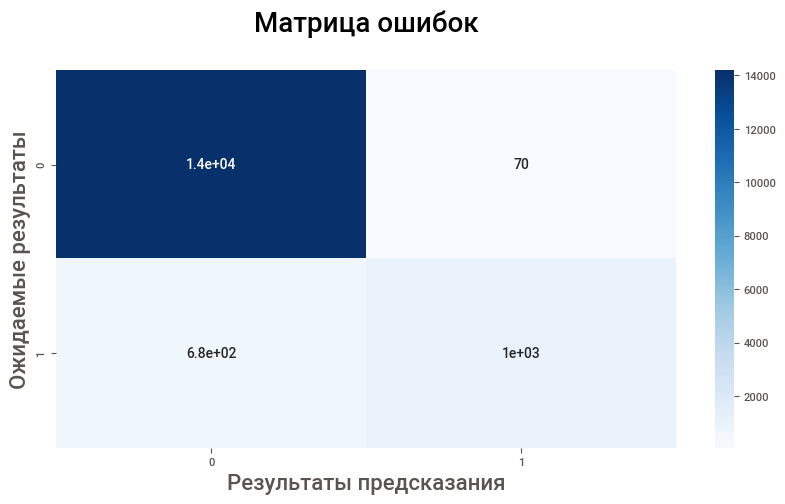

In [30]:
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(confusion_matrix(y_test, pred), annot=True, cmap='Blues')
sns.set_style('white')
heatmap.set_title('Матрица ошибок' + "\n", fontsize=20);
heatmap.set_xlabel('Результаты предсказания', fontsize=16);
heatmap.set_ylabel('Ожидаемые результаты', fontsize=16);
plt.show()

<div style="border:solid steelblue 5px; padding: 30px">
   <p>
        <b>Результаты работы с моделями:</b>
        <ol>
        <li>Разные модели обучены.</li>
        <li>Лучшая модель найдена, сравнена с константной и проверена на тестовой выборке.</li>
        <li>Предсказание оценено.</li>
        </ol>
   </p>  
</div>

## 4 Отчёт

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">

### Описание ключевых шагов решения
1. При подготовке данных была изучена общая информация о данных, очищен и лемматизирован текст, данные разбиты на выборки и текст переведён в векторы.
1. Были обучены разные модели и выбрана лучшая.
1. Лучшая модель была сравнена с константной и протестирована на тестовой выборке.
1. Было оценено предсказание.

***

### Описание модели
Модель — `LinearSVC`.

Гиперпараметры:
- `C` = 2.9016048473696263

***

### Итоговая метрика
F1 0.7787848271231957	

<hr style="color: steelblue; background-color: steelblue; height: 4px; border: none;">